# Predictions on TMDB Datasets

This is a machine learning project that will consist on predicting different things about the TMDB Datasets. The objective of this notebook is to use machine learning.

### Predicting revenue based on budget, runtime and popularity

### Classifying films on genre based on revenue, popularity

## Plan

This is the plan that we are going to follow.

1. read csv file
2. remove columns that have little correlation or we don't need.
3. find if there are null values, dealing either by filling them it using media, average or in worst case dropping them.

In [464]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import json
import os
import sys

## Loading  the dataset 

We are going to load the dataset by merging the two files by movie id.
Then we will remove the columns that are not necesary to our analysis

In [465]:

path1 = "./"
filename_read = os.path.join(path1,"tmdb_5000_movies.csv")
movie = pd.read_csv(filename_read,na_values=['NA','?'])

path2 = "./"
filename_read = os.path.join(path2,"tmdb_5000_credits.csv")
credit = pd.read_csv(filename_read,na_values=['NA','?'])

movies = movie.merge(credit, left_on='id', right_on='movie_id', how='left')
movies.shape

(4803, 24)

## Encoding Non-numerical Features 


We are going to encode the different non numerical features such as crew, cast and genres.
We are going to use one-hot encoding, however this will create many columns, so we will make the first ten rows.

Before we actually can encode the data, we first need to conver the json data from the dataset to an appropiate format that we can use to use one-hot encoding.

The convert() method below, converts the data from the dataframe that is in json format to a list of python

In [466]:
def convert(df, columns): 
    for c in columns:
        # Convert json format to python list
        df[c]=df[c].apply(json.loads)
        
        # Obtain first 10 from columns cast and crew
        if (c == 'cast' or 'crew' or 'production_companies'): 
            for index,i in zip(df.index,df[c]):
                limit = 5
                if len(i) < 5:
                    limit = len(i)
                
                temp_list=[]
                for j in range(limit):
                    # Json format of 'id' & 'name'
                    temp_list.append((i[j]['name'])) 
                df.loc[index,c]= str(temp_list)

        # For any other columns
        else:    
            for index,i in zip(df.index,df[c]):
                temp_list=[]
                for j in range(len(i)):
                    temp_list.append((i[j]['name'])) 
                df.loc[index,c]= str(temp_list)
    
         
        df[c] = df[c].str.strip('[]')       # Remove Sqr Brackets
        df[c] = df[c].str.replace(' ','')   # Remove empty space 
        df[c] = df[c].str.replace("'",'')   # Remove quotations
        df[c] = df[c].str.split(',')        # Format into list
        
        # Sort elements 
        for i,j in zip(df[c],df.index):
            temp_list = i
            temp_list.sort()
            df.loc[j,c]=str(temp_list)
            
        df[c] = df[c].str.strip('[]')       
        df[c] = df[c].str.replace(' ','')    
        df[c] = df[c].str.replace("'",'')   
       
        lst = df[c].str.split(',')        
        if len(lst) == 0:
            df[c] = None
        else:
            df[c]= df[c].str.split(',')
            
    return df

In [467]:
#save columns we do not need before removing
homepage = movies['homepage']
status = movies['status']
overview = movies['overview']
release_date = movies['release_date']
tag_line = movies['tagline']
spoken_languages = movies['spoken_languages']
production_countries = movies['production_countries']
title_x = movies['title_x']
title_y = movies['title_y']

movies = movies.drop(columns=['homepage','original_language','title_y', 'title_x',
                              'overview','production_countries','release_date','spoken_languages','status','tagline', 
                              ], axis=1)

convert(movies,  ['genres', 'keywords', 'production_companies', 'cast', 'crew'])
#test[:5]
movies.shape

(4803, 14)

## Finding basic information about dataset

We will find the basic information about the dataset to deal with null values, duplicate values.

In [468]:
# to observe the data
movies.head()

,budget,genres,id,keywords,original_title,popularity,production_companies,revenue,runtime,vote_average,vote_count,movie_id,cast,crew
0,237000000,"[Action, Adventure, Fantasy, ScienceFiction]",19995,"[cultureclash, future, society, spacecolony, s...",Avatar,150.437577,"[DuneEntertainment, IngeniousFilmPartners, Lig...",2787965087,162.0,7.2,11800,19995,"[MichelleRodriguez, SamWorthington, SigourneyW...","[ChristopherBoyes, ChristopherBoyes, MaliFinn,..."
1,300000000,"[Action, Adventure, Fantasy]",285,"[""loveofoneslife"", drugabuse, eastindiatrading...",Pirates of the Caribbean: At World's End,139.082615,"[JerryBruckheimerFilms, SecondMateProductions,...",961000000,169.0,6.9,4500,285,"[ChowYun-fat, JohnnyDepp, KeiraKnightley, Orla...","[DariuszWolski, GoreVerbinski, JerryBruckheime..."
2,245000000,"[Action, Adventure, Crime]",206647,"[basedonnovel, mi6, secretagent, sequel, spy]",Spectre,107.376788,"[B24, ColumbiaPictures, Danjaq]",880674609,148.0,6.3,4466,206647,"[ChristophWaltz, DanielCraig, LéaSeydoux, Moni...","[AnnaPinnock, JohnLogan, JohnLogan, SamMendes,..."
3,250000000,"[Action, Crime, Drama, Thriller]",49026,"[burglar, crimefighter, dccomics, secretidenti...",The Dark Knight Rises,112.312950,"[DCEntertainment, LegendaryPictures, Syncopy, ...",1084939099,165.0,7.6,9106,49026,"[AnneHathaway, ChristianBale, GaryOldman, Mich...","[CharlesRoven, ChristopherNolan, ChristopherNo..."
4,260000000,"[Action, Adventure, ScienceFiction]",49529,"[basedonnovel, mars, medallion, princess, spac...",John Carter,43.926995,[WaltDisneyPictures],284139100,132.0,6.1,2124,49529,"[LynnCollins, SamanthaMorton, TaylorKitsch, Th...","[AndrewStanton, AndrewStanton, ColinWilson, Ga..."


In [469]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4803 entries, 0 to 4802
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   id                    4803 non-null   int64  
 3   keywords              4803 non-null   object 
 4   original_title        4803 non-null   object 
 5   popularity            4803 non-null   float64
 6   production_companies  4803 non-null   object 
 7   revenue               4803 non-null   int64  
 8   runtime               4801 non-null   float64
 9   vote_average          4803 non-null   float64
 10  vote_count            4803 non-null   int64  
 11  movie_id              4803 non-null   int64  
 12  cast                  4803 non-null   object 
 13  crew                  4803 non-null   object 
dtypes: float64(3), int64(5), object(6)
memory usage: 722.9+ KB


In [470]:
##  Find descriptive stadistics
movies.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count,movie_id
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989,57165.484281
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891,88694.614033
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,5.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000,9014.500000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000,14629.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000,58610.500000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000,459488.000000


## Cleaning the dataset

We are going to clean the dataset before prediction. We made those methods to remove the outliers from the data, and remove any null values, 

In [471]:

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, sd):
    col_names = df.columns.values
    df_col_types = dict(df.dtypes)

    for name, t in df_col_types.items():
        if t != np.object:
            name = str(name)
            drop_rows = df.index[(np.abs(df[name] - df[name].mean())
                          >= (sd * df[name].std()))]
            df.drop(drop_rows, axis=0, inplace=True)
    
# Convert all missing values in the specified column to the default filling with mean of column
def remove_missing(df, nullRatios, drop_col_ratio):
    # find mean of column skipping na
    meanv = df.mean(axis=1, skipna=True)
    col_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'object']
    df_col_types = dict(df.dtypes)
    #percentage to fill or drop, if bigger the column is dropped
    minPercent = drop_col_ratio

    for k, v in nullRatios.items():

        print(k)
    
        if v > minPercent:
            df.drop(str(k), axis=1, inplace=True)
            #print(df.columns.values)       
        elif df_col_types[str(k)] == np.object:
            df.dropna(how='any', axis=0, inplace=True)
        else:
            
            df.fillna(value={k: meanv}, axis=0, inplace=True)
    
    #df[name] = df[name].fillna(default_value)
    
# find the ratio of nulls compared to total rows to determined if the null value should be filled ot .
def find_missing_ratio(data):
    
    nullRatios = {}
    
    for val in list(data.columns.values):
        nullValuesCol = data[val].isnull().sum()
        totalCol = len(data[val])

        ratio = (nullValuesCol / totalCol) * 100
    
        if ratio > 0:
            nullRatios[val] = ratio

    # print values 
    for k, v in nullRatios.items():
        print('Column {key} has a ratio of {value}'.format(key = k, value = v))
        print(k)

    return nullRatios

In [472]:
movies.columns


Index(['budget', 'genres', 'id', 'keywords', 'original_title', 'popularity',
       'production_companies', 'revenue', 'runtime', 'vote_average',
       'vote_count', 'movie_id', 'cast', 'crew'],
      dtype='object')

In [473]:
# get numeric and columns only

ratio_null = find_missing_ratio(movies)
remove_missing(movies, ratio_null, 20)
remove_outliers(movies, 2)

drop = []
for i in movies.index:
    if (movies['production_companies'][i] == [''] and movies['cast'][i] == [''] and  movies['crew'][i] == ['']):
        drop.append(i)

movies = movies.drop(drop, axis = 0)

#mask_avg = (movies['budget'] != 0)
#movies = movies[mask_avg]
#print(movies[mask_avg].shape)

print(movies.shape)
print(movies.dtypes)

Column runtime has a ratio of 0.041640641265875494
runtime
runtime
(3179, 14)
budget                    int64
genres                   object
id                        int64
keywords                 object
original_title           object
popularity              float64
production_companies     object
revenue                   int64
runtime                 float64
vote_average            float64
vote_count                int64
movie_id                  int64
cast                     object
crew                     object
dtype: object


In [474]:
#checking how many values are the
movies.isnull().sum()

budget                  0
genres                  0
id                      0
keywords                0
original_title          0
popularity              0
production_companies    0
revenue                 0
runtime                 0
vote_average            0
vote_count              0
movie_id                0
cast                    0
crew                    0
dtype: int64

## Finding and plotting correlation between columns

We will use a heatmap to make the correlation matrix  of the columns to find if there is relationships between columns. 

Also we will use the corr() function to visualise how the data is distributed. 

<AxesSubplot:>

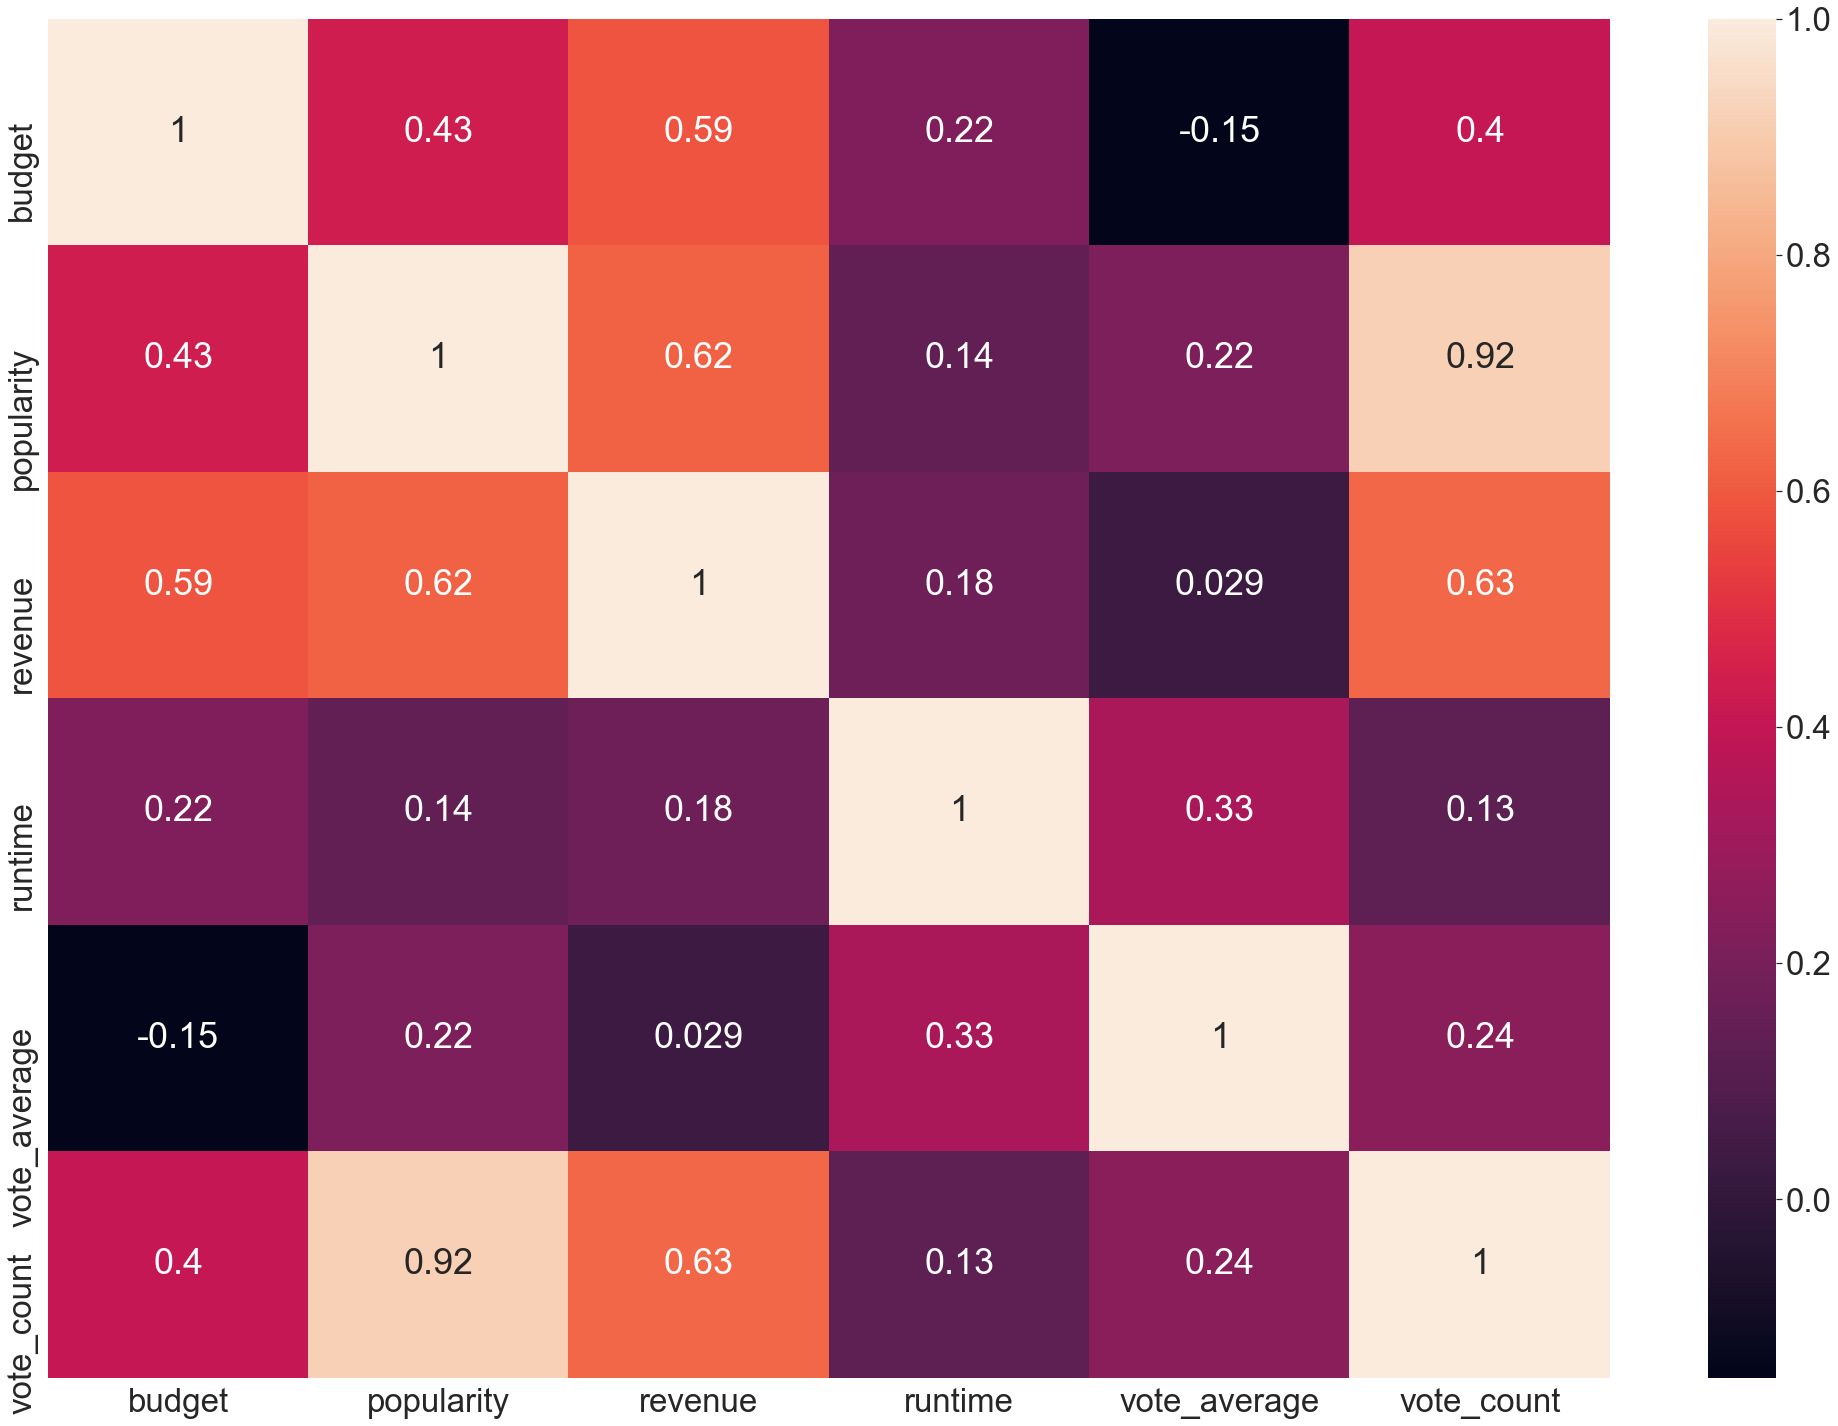

In [475]:
##  find correlations between columns using a correlation matrix

data = movies.drop(['id', 'movie_id'], axis=1)
sns.set(font_scale=3)
plt.figure(figsize=(35, 25))
sns.heatmap(data.corr(method='pearson'), annot=True)


array([[<AxesSubplot:title={'center':'budget'}>,
        <AxesSubplot:title={'center':'popularity'}>],
       [<AxesSubplot:title={'center':'revenue'}>,
        <AxesSubplot:title={'center':'runtime'}>],
       [<AxesSubplot:title={'center':'vote_average'}>,
        <AxesSubplot:title={'center':'vote_count'}>]], dtype=object)

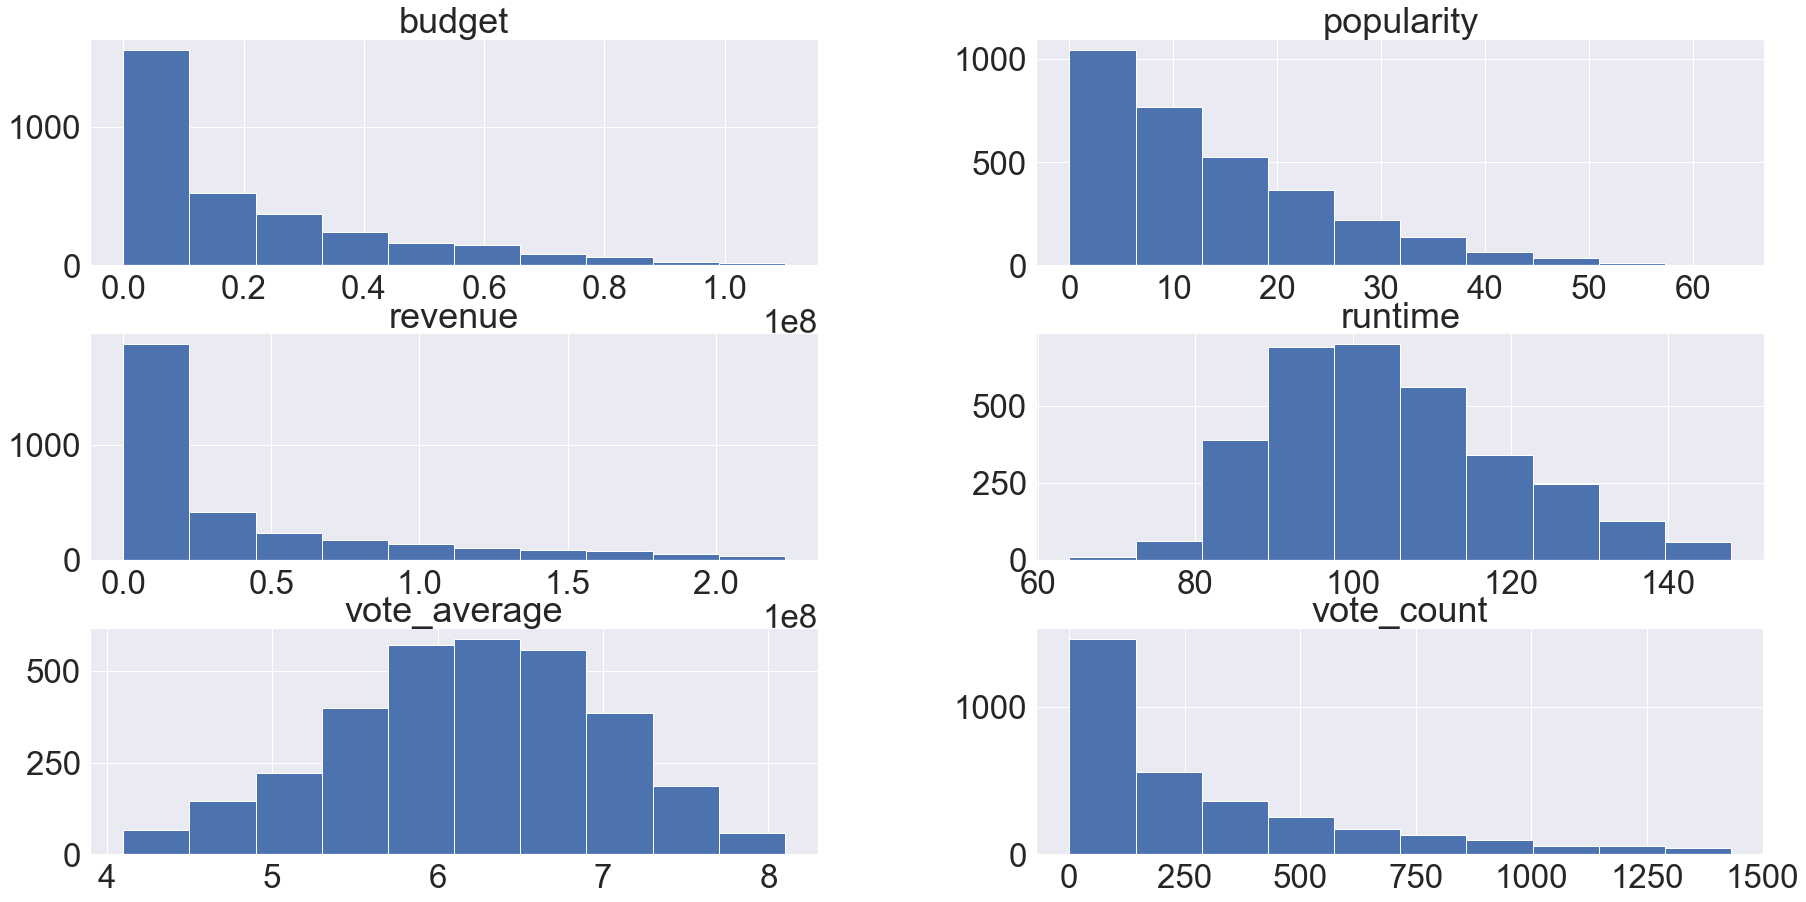

In [476]:

data.hist(bins=10, figsize=(30, 15))

<Figure size 2160x2160 with 0 Axes>

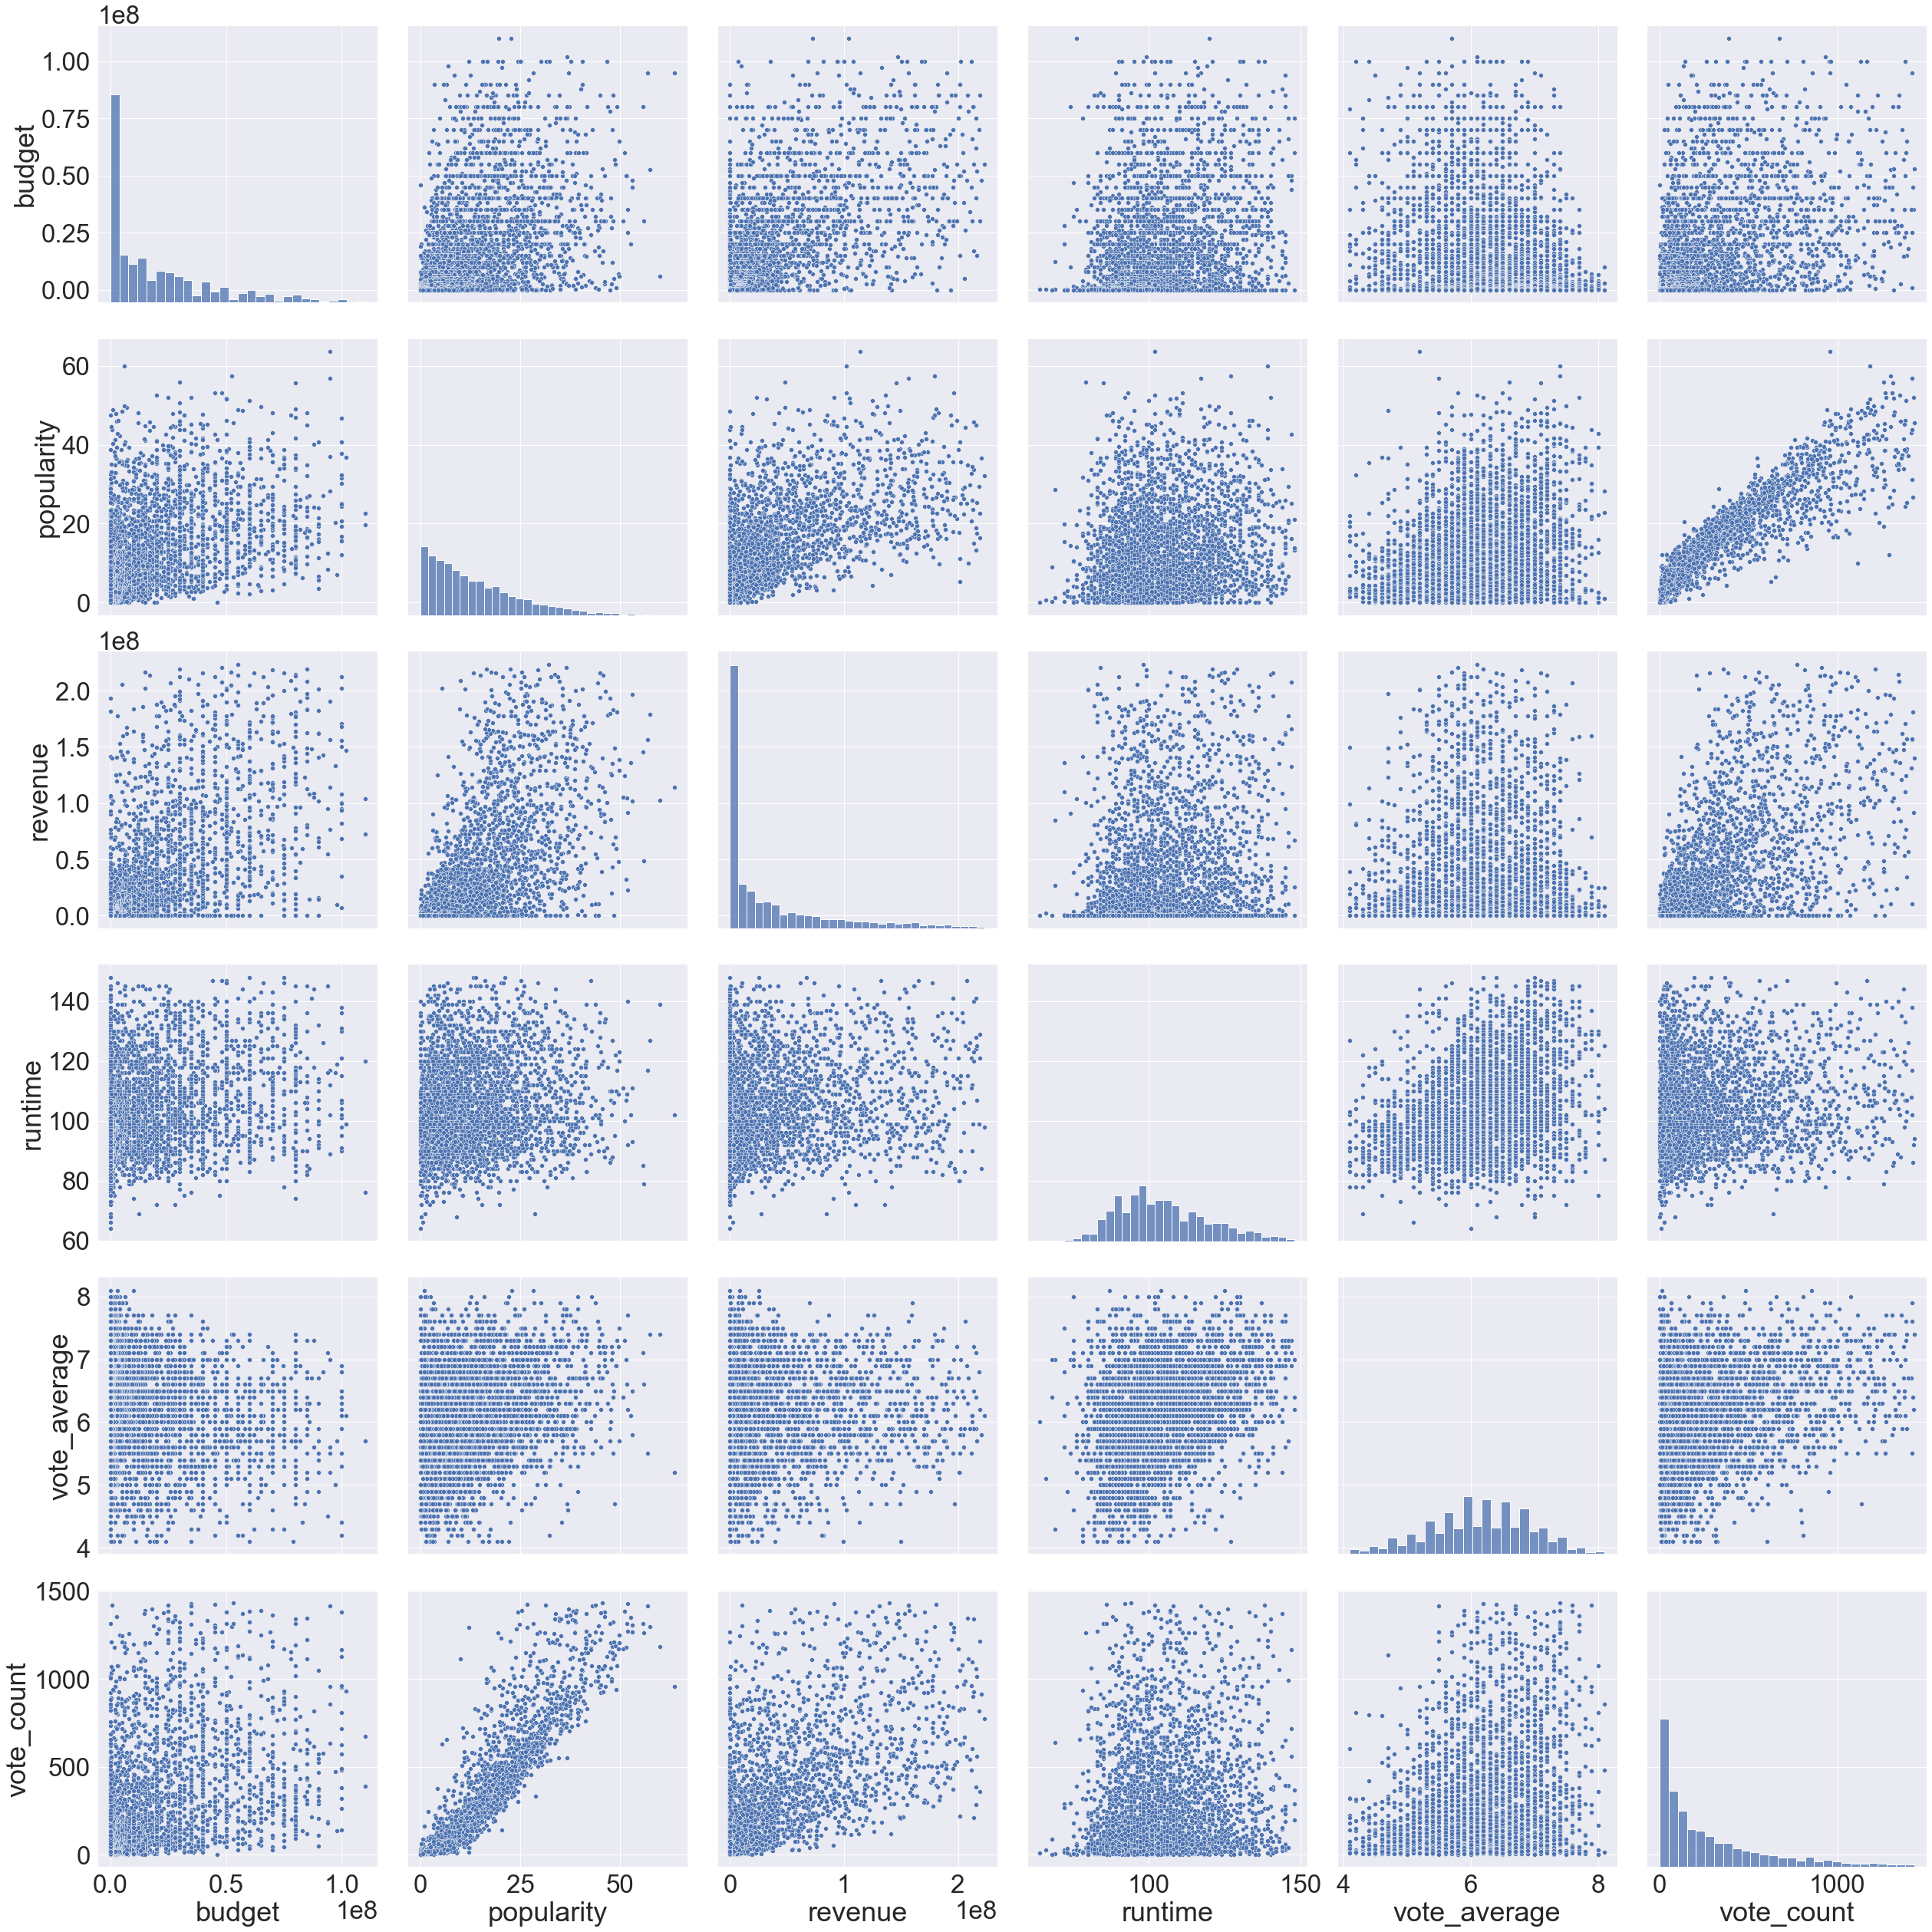

(3179, 12)

In [477]:
# show correlations to see how the data is distributed to apply different models.
plt.figure(figsize=(30, 30))
sns.pairplot(data, height=6, diag_kind='hist')
plt.show()
data.shape

## Findings

### Budget:

- Budget and runtime is normally distributed, therefore as the runtime ranges around 100, then the budget is great. 
- Budget and popularity follow a linear relationship, therefore Linear regression could be used to predict price. Larger budgets then to produce more popular films.

### Revenue

- Revenue and runtime is normally distributed, therefore as the runtime ranges around 100, then the budget is great. 
- Revenue and popularity follow a linear relationship, therefore Linear regression could be used to predict price. Popular fims tend to generate more revenue.
  
#### Budget and revenue have some linear correlation, although not as much as popularity. 

## Revenue Predictions 

We will try to predict price based on a number of features.

We will start by using regression, either lineal regression or logistic regression, the features will come from the analisis made previously. 

In [478]:
#Select only numeric_types and make a copy to not modify the original
predData = movies.copy().drop(['movie_id', 'id', 'vote_average'], axis=1)
predData = predData.select_dtypes(include=['int64', 'float64']).copy()
predData
predData.shape

(3179, 5)

### Obtaining X and y.

We are going to obtain X and y, we will reindex the data and then put all the data into the X variable except the 'revenue' columns which is what we try to predict, based on popularity, vote_count and budget.

y vairable will have the revenue column. 

We check the shape to see what shape the variables have and as a way to check that what we did was right.

In [479]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import LeaveOneOut

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
#from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA 
from sklearn import metrics
# Reindex the data.
predData = predData.reindex(np.random.permutation(predData.index))

result = []

#Go through columns
for x in predData.columns:
    #If column is not revenue then append the col value (str) to result.
    if x != 'revenue':
        result.append(x)

#Get values using masking from columns
X = predData[result].values
#Conver to similar shape that y
print(X.shape)

print("original shape: ", X.shape) 
#print("transformed shape:", X_pca.shape)

y = predData['revenue'].values
print(y.shape)

print(X.shape)


#plt.scatter(X, y)

(3179, 4)
original shape:  (3179, 4)
(3179,)
(3179, 4)


Using cross validation methods by holdout method and by Kfold_cv. We tried cross valiadation splitting into 5 folds, we set shuffle to false as we previously shuffle the data, we will get our training sets and testing sets based on the cross_validation.

We then use StandardScaler to standarise the data, by using the fit method on the training set and then transform the data. The method used is to subtract the mean from every datapoint and then substract by z.


In [480]:
#Using holdout sets 
#X_train, y_train, X_test, y_test = train_test_split(X, y, random_state=9, test_size=0.25)
kfold_cv=KFold(n_splits=5, shuffle=False)

for train_index, test_index in kfold_cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)



#print('Mean:', np.mean(y_test))
from sklearn.preprocessing import StandardScaler
#X_train = np.log(X_train)
#X_test = np.log(X_test)
scaler = StandardScaler()
#scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
scaler.fit(X_test)
X_test = scaler.transform(X_test)
#print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))##

(2544, 4)
(2544,)
(635, 4)
(635,)


### Linear Regression

Choosing Linear regression model. LinearRegression model will be use to make the regression. The 'fit_intercept' tells to calculate  the intercept, and the normalize parameter tells to normalise the data before the regression. The Copy_X will copy the data. The scoring metric will be neg_mean_squared_error.

In [481]:
model = LinearRegression()
X_train_linreg = X_train.copy()
y_train_linreg = y_train.copy()
X_test_linreg = X_test.copy()
y_test_linreg = y_test.copy()
params = {'fit_intercept':[True, False], 'normalize':[True, False], 'copy_X':[True, False]}
grid_search = GridSearchCV(model, param_grid=params, verbose=2, scoring='neg_mean_squared_error')
grid_search.fit(X_train_linreg, y_train_linreg)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(best_params)
print(best_score)

y_pred = grid_search.predict(X_test_linreg)
#print(reg.intercept_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] copy_X=True, fit_intercept=True, normalize=True .................
[CV] .. copy_X=True, fit_intercept=True, normalize=True, total=   0.0s
[CV] copy_X=True, fit_intercept=True, normalize=True .................
[CV] .. copy_X=True, fit_intercept=True, normalize=True, total=   0.0s
[CV] copy_X=True, fit_intercept=True, normalize=True .................
[CV] .. copy_X=True, fit_intercept=True, normalize=True, total=   0.0s
[CV] copy_X=True, fit_intercept=True, normalize=True .................
[CV] .. copy_X=True, fit_intercept=True, normalize=True, total=   0.0s
[CV] copy_X=True, fit_intercept=True, normalize=True .................
[CV] .. copy_X=True, fit_intercept=True, normalize=True, total=   0.0s
[CV] copy_X=True, fit_intercept=True, normalize=False ................
[CV] . copy_X=True, fit_intercept=True, normalize=False, total=   0.0s
[CV] copy_X=True, fit_intercept=True, normalize=False ................
[CV] . copy_X=Tru

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.1s finished


In [482]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# prints the stats of the different regression models
def print_regression_stats(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2_square =r2_score(y_test, y_pred)
    
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)

    print('y_pred shape', y_pred.shape)
    print('y_test shape', y_test.shape)

print_regression_stats(y_test, y_pred)


MAE: 22819142.09653269
MSE: 1207392799839989.0
RMSE: 34747558.1852882
R2 Square 0.5366913700488812
y_pred shape (635,)
y_test shape (635,)


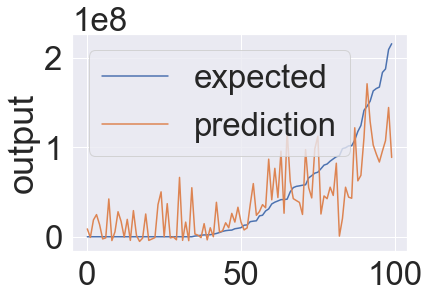

In [483]:
#plots the chart of the prediction vs expected values.
def chart_regression(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y.flatten()})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['y'].tolist(), label='expected')
    plt.plot(t['pred'].tolist(), label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()
    

chart_regression(y_pred[:100].flatten(), y_test_linreg[:100].flatten(), sort=True)

Using linear regression we are getting values around 54%.

### Ridge Regression
The Ridge model uses Linear least squares with l2 regularization.

Minimizes the objective function:

||y - Xw||^2_2 + alpha * ||w||^2_2.

The alphas parameters are parameters that improves the regularization of the algorithm. Larger values specify stronger regularization. 

{'alpha': 0.001, 'normalize': True}
-1183865951364205.5
MAE: 22821005.7727177
MSE: 1207458682892592.0
RMSE: 34748506.196563214
R2 Square 0.536666088974783
y_pred shape (635,)
y_test shape (635,)


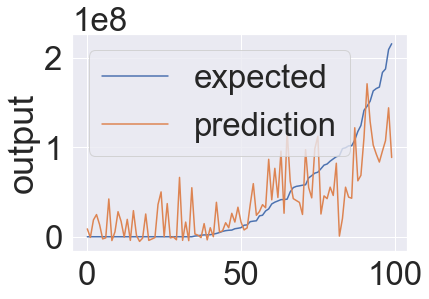

In [484]:
from sklearn.linear_model import Ridge

X_train_ridgereg = X_train.copy()
y_train_ridgereg = y_train.copy()
X_test_ridgereg = X_test.copy()
y_test_ridgereg = y_test.copy()
model = Ridge()
#prepare a range of alpha values to test
alphas = np.array([1,0.2,0.1, 0.01, 0.001, 0.0001, 0])
normalizes = ([True, False])

grid_search = GridSearchCV(estimator=model,  
                         param_grid=(dict(alpha=alphas, normalize= normalizes)),
                         scoring='neg_mean_squared_error',
                         n_jobs=-1)


grid_search.fit(X_train_ridgereg, y_train_ridgereg)
print(grid_search.best_params_)
print(grid_search.best_score_)
y_pred = grid_search.predict(X_test_ridgereg)
print_regression_stats(y_test_ridgereg, y_pred)

chart_regression(y_pred[:100].flatten(), y_test_ridgereg[:100].flatten(), sort=True)

### Polynomial Regression

The polynomial regression will work by transforming the data. We are transforming X_train, and X_test

In [485]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2)
X_poly_train = X_train.copy()
X_poly_test = X_test.copy()
y_poly_train = y_train.copy()
y_poly_test = y_test.copy()

X_poly_train = poly_features.fit_transform(X_poly_train)
X_poly_test = poly_features.fit_transform(X_poly_test)


### Linear Regression with polinomial
Then the LinearRegression model will be use to make the regression. The 'fit_intercept' tells to calculate  the intercept, and the normalize parameter tells to normalise the data before the regression. The Copy_X will copy the data.


In [486]:
model = LinearRegression()
X_poly_train_lin = X_poly_train.copy()
params = {'fit_intercept':[True, False], 'normalize':[True, False], 'copy_X':[True, False]}
grid_search = GridSearchCV(model, param_grid=params, verbose=2, scoring='neg_mean_squared_error')
grid_search.fit(X_poly_train, y_poly_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(best_params)
print(best_score)

y_pred = grid_search.predict(X_poly_test)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] copy_X=True, fit_intercept=True, normalize=True .................
[CV] .. copy_X=True, fit_intercept=True, normalize=True, total=   0.0s
[CV] copy_X=True, fit_intercept=True, normalize=True .................
[CV] .. copy_X=True, fit_intercept=True, normalize=True, total=   0.0s
[CV] copy_X=True, fit_intercept=True, normalize=True .................
[CV] .. copy_X=True, fit_intercept=True, normalize=True, total=   0.0s
[CV] copy_X=True, fit_intercept=True, normalize=True .................
[CV] .. copy_X=True, fit_intercept=True, normalize=True, total=   0.0s
[CV] copy_X=True, fit_intercept=True, normalize=True .................
[CV] .. copy_X=True, fit_intercept=True, normalize=True, total=   0.0s
[CV] copy_X=True, fit_intercept=True, normalize=False ................
[CV] . copy_X=True, fit_intercept=True, normalize=False, total=   0.0s
[CV] copy_X=True, fit_intercept=True, normalize=False ................
[CV] . copy_X=Tru

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.1s finished


MAE: 22090337.054930545
MSE: 1147226974088886.8
RMSE: 33870739.201985046
R2 Square 0.5597785926183012
y_pred shape (635,)
y_test shape (635,)


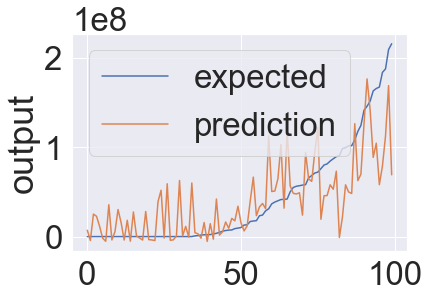

In [487]:
print_regression_stats(y_poly_test, y_pred)
chart_regression(y_pred[:100].flatten(), y_poly_test[:100].flatten(), sort=True)

As we can observe from the graph, we are able to get around 0.60 of R2 value by using polinomial of degree 2. We got 0.51 using polynomial of degree 3. 

### Ridge regression with polynomial regression

In [488]:
model = Ridge()
#prepare a range of alpha values to test
alphas = np.array([1, 0.1, 0.01, 0.001, 0.0001, 0])
normalizes = ([True, False])

grid_search = GridSearchCV(estimator=model,  
                         param_grid=(dict(alpha=alphas, normalize= normalizes)),
                         scoring='neg_mean_squared_error',
                         n_jobs=-1, verbose=True)


grid_search.fit(X_poly_train, y_poly_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

y_pred = grid_search.predict(X_poly_test)



Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'alpha': 0.001, 'normalize': True}
-1122468194578990.6


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.1s finished


In [489]:
print_regression_stats(y_poly_test, y_pred)

MAE: 22096516.419543095
MSE: 1147588457585048.5
RMSE: 33876075.002648234
R2 Square 0.5596398818164985
y_pred shape (635,)
y_test shape (635,)


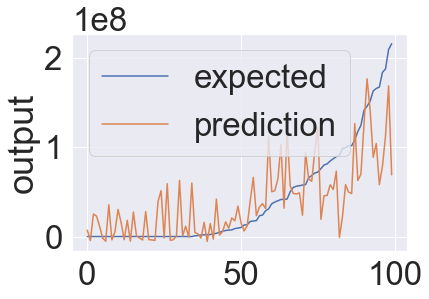

In [490]:
chart_regression(y_pred[:100].flatten(), y_poly_test[:100].flatten(), sort=True)


We got around 55% using Ridge and polynomial regression

### Neural Network

In [491]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import  Flatten
from keras.constraints import maxnorm

In [492]:


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(
        target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    # Regression
    return df[result].values.astype(np.float32), df[[target]].values.astype(np.float32)


#X, y = to_xy(movies, 'revenue')
"""
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)
def create_model():
    input_dim = len(predData.columns)
    activation = 'relu'
    dropout_rate = 0.0
    init_mode='uniform'
    weight_constraint = 0
    optimizer = 'adam'
    lr=0.01
    momentum=0
    
    model = Sequential()
    model.add(Flatten(input_shape=[X_train.shape[1]]))
    model.add(Dense(8, activation=activation, kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dense(8, activation=activation))
    model.add(Dropout(dropout_rate))
    #model.add(Dense())
    #model.add(Dense(1, kernel_initializer=init_mode, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model"""

def select_optimizer(optimizer_type, learning_rate, momentum):
    if optimizer_type == 'SGD':
        return SGD(learning_rate=learning_rate, momentum=momentum)
def create_model(optimizer = 'adam'):
    input_dim = X_train.shape[0]
    activation = 'relu'
    dropout_rate = 0.0
    init_mode='uniform'
    weight_constraint = 0
    
    learn_rate=0.01
    momentum=0

    model = Sequential()

    model.add(Flatten(input_shape=[X_train.shape[1]]))
    model.add(Dense(1, input_dim=input_dim, kernel_initializer=init_mode, activation=activation, kernel_constraint=maxnorm(weight_constraint)))
    #model.add(Dense(20, activation=activation, kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    #model.add(Dense(30, activation=activation))
    model.add(Dense(1, input_dim=input_dim, kernel_initializer=init_mode, activation='sigmoid'))
    #model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['accuracy'])

    return model


"""def create_model(learn_rate=0.01, momentum=0):
    # create model
    model = Sequential()
    model.add(Dense(6, input_dim=predData.shape[1], activation='relu'))
    #model.add(Dense())
    model.add(Dense(1, input_dim=6, activation='sigmoid'))
    # Compile model
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model"""

"def create_model(learn_rate=0.01, momentum=0):\n    # create model\n    model = Sequential()\n    model.add(Dense(6, input_dim=predData.shape[1], activation='relu'))\n    #model.add(Dense())\n    model.add(Dense(1, input_dim=6, activation='sigmoid'))\n    # Compile model\n    optimizer = SGD(lr=learn_rate, momentum=momentum)\n    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])\n    return model"

### Trial using grid search.


In [493]:
"""
model = KerasRegressor(build_fn=create_model, batch_size=10, epochs=10)
print(X_train.shape, y_train.shape)
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 30 ,50, 100]
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
neurons = [1, 5, 10, 15, 20, 25, 30]
init = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
params = dict(epochs=epochs, 
          batch_size=batch_size, optimizer=optimizer)##, init=init,learn_rate=learn_rate, momentum=momentum
          #'optimizer': optimizer,
          #'learn_rate': learn_rate,
          #'momentum': momentum,
          #'neurons': neurons
#params = dict(optimizer=optimizer)

train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
print(X_test.shape, y_test.shape)
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))
#print(train_data.shape, test_data.shape)
grid_search = GridSearchCV(model, param_grid=params, verbose=2, n_jobs=-1)
result = grid_search.fit(X_train, y_train)"""

#result = grid_search.fit(train_data, validation_data=test_data)
#model.add(Dense(12, input_dim=len(predData.columns), activation='relu'))
#model.add(Dense(12, input_dim=len(predData.columns), activation='sigmoid'))



"\nmodel = KerasRegressor(build_fn=create_model, batch_size=10, epochs=10)\nprint(X_train.shape, y_train.shape)\noptimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']\n\nbatch_size = [10, 20, 40, 60, 80, 100]\nepochs = [10, 30 ,50, 100]\nlearn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]\nmomentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]\nneurons = [1, 5, 10, 15, 20, 25, 30]\ninit = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']\nparams = dict(epochs=epochs, \n          batch_size=batch_size, optimizer=optimizer)##, init=init,learn_rate=learn_rate, momentum=momentum\n          #'optimizer': optimizer,\n          #'learn_rate': learn_rate,\n          #'momentum': momentum,\n          #'neurons': neurons\n#params = dict(optimizer=optimizer)\n\ntrain_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))\nprint(X_test.shape, y_test.shape)\ntest_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))\n#print

In [494]:

print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -1122468194578990.625000 using {'alpha': 0.001, 'normalize': True}
-1313743473740575.000000 (93789926236195.453125) with: {'alpha': 1.0, 'normalize': True}
-1122619270205395.375000 (66878212400656.945312) with: {'alpha': 1.0, 'normalize': False}
-1142028763908662.500000 (76810180521443.843750) with: {'alpha': 0.1, 'normalize': True}
-1122671507168642.750000 (66787344485997.828125) with: {'alpha': 0.1, 'normalize': False}
-1122614595063041.750000 (68696910019513.179688) with: {'alpha': 0.01, 'normalize': True}
-1122677280832382.375000 (66778227656695.789062) with: {'alpha': 0.01, 'normalize': False}
-1122468194578990.625000 (66949311986766.953125) with: {'alpha': 0.001, 'normalize': True}
-1122677863863436.375000 (66777315685881.132812) with: {'alpha': 0.001, 'normalize': False}
-1122653202480407.625000 (66793383511604.742188) with: {'alpha': 0.0001, 'normalize': True}
-1122677922223358.375000 (66777224485934.023438) with: {'alpha': 0.0001, 'normalize': False}
-1122677928708432.62

In [495]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')
model = Sequential()

model.add(Flatten(input_shape=[X_train.shape[1]]))
#model.add(Dense(24, kernel_initializer='normal',  activation='relu'))
#model.add(Dense(16, kernel_initializer='normal',  activation='relu'))

#model.add(Dense(8, kernel_initializer='uniform',  activation='sigmoid'))

#model.add(Dropout(0.20))
model.add(Dense(2, kernel_initializer='uniform',  activation='relu', kernel_constraint=maxnorm(0)))
model.add(Dense(4, kernel_initializer='uniform',  activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(8, kernel_initializer='uniform',  activation='relu'))
model.add(Dense(4, kernel_initializer='uniform',  activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
optimizer = SGD(learning_rate=2, momentum=0.2)
mse = tf.keras.losses.MeanAbsolutePercentageError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
mse(y_test, y_pred).numpy()
model.compile(optimizer=optimizer, loss=mse, metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=10, epochs=50)

Epoch 1/50
255/255 [==============================] - 1s 922us/step - loss: 4784736.4680 - accuracy: 0.3287
Epoch 2/50
255/255 [==============================] - 0s 893us/step - loss: 69.0791 - accuracy: 0.3092
Epoch 3/50
255/255 [==============================] - 0s 963us/step - loss: 68.2220 - accuracy: 0.3178
Epoch 4/50
255/255 [==============================] - 0s 896us/step - loss: 69.8634 - accuracy: 0.3014
Epoch 5/50
255/255 [==============================] - 0s 770us/step - loss: 68.6909 - accuracy: 0.3131
Epoch 6/50
255/255 [==============================] - 0s 991us/step - loss: 66.3795 - accuracy: 0.3362
Epoch 7/50
255/255 [==============================] - 0s 878us/step - loss: 67.9161 - accuracy: 0.3208
Epoch 8/50
255/255 [==============================] - 0s 889us/step - loss: 68.6267 - accuracy: 0.3137
Epoch 9/50
255/255 [==============================] - 0s 823us/step - loss: 68.5278 - accuracy: 0.3147
Epoch 10/50
255/255 [==============================] - 0s 913us/step

In [496]:
y_pred = model.predict(X_test)
y_pred.shape


(635, 1)

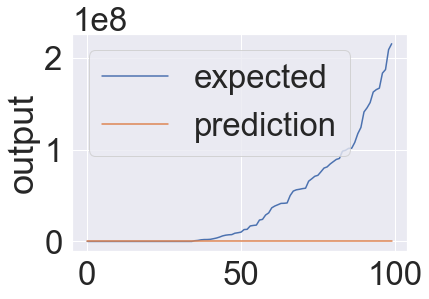

In [497]:
#y_pred = grid_search.predict(X_test)
chart_regression(y_pred[:100].flatten(), y_test[:100].flatten(), sort=True)

## Process Finding of parameters

### First Trial
To find the parameters to implement a neural network starting with one 2 hidden layers with 8 neurons in each layers, and a drop-out rate that will not be used as our first trial. The results showed that is was not working as it should, we were getting between 5% to 10% of accuracy. The activation function is relu for the hidden layers and sigmoid for the output layer, fo the loss function, categorical_crossentropy was used.


### Second Trial
We added another layer and change the number of neurons to the first one to 80, the second layer has 50 neuros with dropout rate of 0.0 and the third layer has 30 neurons and using relu as activation function for the hidden layers and sigmoid for the output layer. We still get 5% to 10%. The gridsearch tell us that the best predictor is to use SGD instead of Adam optimizer, and to use size of 10 batches and 10 epochs. For the loss function mean squared error was used.

### Third Trial
We tried to implement it manually as it was not working with gridsearch, we got 30% accuracy, we tried to change different optimizers such as Adam, SGD, it works the best with SGD. We tried different loss functions, such as categorical_crossentropy, binary_crossentropy, Poisson, Mean_absolute_error. The best results were using categorical_crossentropy

### Fourth Trial
We tried with different number of neurons using to a smaller number, such as 4 for hidden layer 1, 8 for second hidden layer and 4 for third layer. We also tried different optimizers such as adam and change the learning rate to 0.02, 0.2, 2, 0.0023, and it did not make any significant change on the data. The dropout rate was 0.25